In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


In [4]:
def load_mnist(batch_size=64):

    transform = transforms.ToTensor()

    trainset = torchvision.datasets.MNIST(
        root='./data', train=True,
        download=True, transform=transform)

    testset = torchvision.datasets.MNIST(
        root='./data', train=False,
        download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


In [5]:
def load_cifar(batch_size=64):

    transform = transforms.ToTensor()

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True,
        download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False,
        download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


In [6]:
class LeNet5(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.fc3(x)


In [7]:
class VGGNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3,64,3,padding=1), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128,256,3,padding=1), nn.ReLU(),
            nn.Conv2d(256,256,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(

            nn.Linear(256*4*4,1024),
            nn.ReLU(),

            nn.Linear(1024,1024),
            nn.ReLU(),

            nn.Linear(1024,10)
        )

    def forward(self,x):

        x = self.features(x)
        x = x.view(x.size(0),-1)

        return self.classifier(x)


In [8]:
class AlexNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,192,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(192,384,3,padding=1),
            nn.ReLU(),

            nn.Conv2d(384,256,3,padding=1),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(

            nn.Linear(256*4*4,1024),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(1024,1024),
            nn.ReLU(),

            nn.Linear(1024,10)
        )

    def forward(self,x):

        x = self.features(x)
        x = x.view(x.size(0),-1)

        return self.classifier(x)


In [9]:
class ResidualBlock(nn.Module):

    def __init__(self, ch):
        super().__init__()

        self.conv1 = nn.Conv2d(ch,ch,3,padding=1)
        self.conv2 = nn.Conv2d(ch,ch,3,padding=1)

    def forward(self,x):

        y = F.relu(self.conv1(x))
        y = self.conv2(y)

        return F.relu(x+y)


In [10]:
class ResNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(3,64,3,padding=1)

        self.block1 = ResidualBlock(64)
        self.block2 = ResidualBlock(64)

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(64,10)

    def forward(self,x):

        x = F.relu(self.conv(x))

        x = self.block1(x)
        x = self.block2(x)

        x = self.pool(x)

        x = x.view(x.size(0),-1)

        return self.fc(x)


In [11]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):

        ce = F.cross_entropy(inputs, targets, reduction='none')

        pt = torch.exp(-ce)

        return ((1-pt)**self.gamma * ce).mean()


In [12]:
class ArcFaceLoss(nn.Module):

    def __init__(self, s=30, m=0.5):
        super().__init__()

        self.s = s
        self.m = m

    def forward(self, logits, labels):

        one_hot = torch.zeros_like(logits)

        one_hot.scatter_(1, labels.view(-1,1), 1)

        logits = logits - one_hot*self.m

        return F.cross_entropy(self.s*logits, labels)


In [13]:
def train_part2(model, loader, loss_fn, optimizer, epochs):

    model.train()

    for epoch in range(epochs):

        correct = 0
        total = 0
        running_loss = 0

        for x,y in loader:

            optimizer.zero_grad()

            out = model(x)

            loss = loss_fn(out,y)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            _,pred = torch.max(out,1)

            total += y.size(0)

            correct += (pred==y).sum().item()

        print("Epoch:",epoch+1,
              "Loss:",running_loss/len(loader),
              "Accuracy:",100*correct/total)


In [14]:
trainloader, testloader = load_mnist()

model = LeNet5()

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss = nn.CrossEntropyLoss()

train_part2(model, trainloader, loss, optimizer, 5)


100%|██████████| 9.91M/9.91M [00:06<00:00, 1.51MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 44.2kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 747kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.09MB/s]


Epoch: 1 Loss: 0.38854906510220155 Accuracy: 88.26166666666667
Epoch: 2 Loss: 0.11473320727584077 Accuracy: 96.515
Epoch: 3 Loss: 0.07666913663341936 Accuracy: 97.65333333333334
Epoch: 4 Loss: 0.058808556650139725 Accuracy: 98.17833333333333
Epoch: 5 Loss: 0.04704892682147397 Accuracy: 98.51166666666667


In [25]:
def test_model(model, loader):

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():

        for x, y in loader:

            out = model(x)

            _, pred = torch.max(out, 1)

            total += y.size(0)
            correct += (pred == y).sum().item()

    acc = 100 * correct / total

    return acc


In [16]:
trainloader, testloader = load_cifar()
model = AlexNet()

loss = FocalLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_part2(model, trainloader, loss, optimizer, 20)


100%|██████████| 170M/170M [01:05<00:00, 2.61MB/s]   


Epoch: 1 Loss: 1.7479904100413213 Accuracy: 15.958
Epoch: 2 Loss: 1.2214069748321152 Accuracy: 34.466
Epoch: 3 Loss: 0.9609270140033244 Accuracy: 45.218
Epoch: 4 Loss: 0.780760052259011 Accuracy: 53.816
Epoch: 5 Loss: 0.6388560329632991 Accuracy: 61.124
Epoch: 6 Loss: 0.523532582747052 Accuracy: 67.578
Epoch: 7 Loss: 0.43768350033046644 Accuracy: 72.066
Epoch: 8 Loss: 0.3757913495268663 Accuracy: 75.614
Epoch: 9 Loss: 0.3165100031934888 Accuracy: 78.112
Epoch: 10 Loss: 0.2632667034521432 Accuracy: 81.334
Epoch: 11 Loss: 0.21669413166506515 Accuracy: 83.674
Epoch: 12 Loss: 0.1683427891300996 Accuracy: 86.82
Epoch: 13 Loss: 0.13095379543616947 Accuracy: 88.956
Epoch: 14 Loss: 0.09997968157739057 Accuracy: 90.88
Epoch: 15 Loss: 0.07575606814969112 Accuracy: 92.694
Epoch: 16 Loss: 0.05556917282493066 Accuracy: 94.454
Epoch: 17 Loss: 0.04631199882558697 Accuracy: 95.23
Epoch: 18 Loss: 0.03221965120132308 Accuracy: 96.68
Epoch: 19 Loss: 0.02644028730751218 Accuracy: 97.212
Epoch: 20 Loss: 0.

In [26]:
test_acc = test_model(model, testloader)

print("Test Accuracy:", test_acc)


Test Accuracy: 72.65


In [17]:
model = VGGNet()

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_part2(model, trainloader, loss, optimizer, 10)

Epoch: 1 Loss: 1.815709987869653 Accuracy: 31.3
Epoch: 2 Loss: 1.2053214345136871 Accuracy: 56.302
Epoch: 3 Loss: 0.9339419320568709 Accuracy: 66.802
Epoch: 4 Loss: 0.7701693778605108 Accuracy: 72.736
Epoch: 5 Loss: 0.6539919489180036 Accuracy: 76.928
Epoch: 6 Loss: 0.5501589165509814 Accuracy: 80.49
Epoch: 7 Loss: 0.4634181094710784 Accuracy: 83.62
Epoch: 8 Loss: 0.38610632746192197 Accuracy: 86.212
Epoch: 9 Loss: 0.3272047325054093 Accuracy: 88.3
Epoch: 10 Loss: 0.272578980073409 Accuracy: 90.298


In [27]:
test_acc = test_model(model, testloader)

print("Test Accuracy:", test_acc)


Test Accuracy: 72.65


In [18]:
model = ResNet()

loss = ArcFaceLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_part2(model, trainloader, loss, optimizer, 15)


Epoch: 1 Loss: 16.413983682842204 Accuracy: 33.428
Epoch: 2 Loss: 15.176666073177172 Accuracy: 45.744
Epoch: 3 Loss: 13.860532021583499 Accuracy: 52.656
Epoch: 4 Loss: 12.91773638396007 Accuracy: 57.454
Epoch: 5 Loss: 12.146741054856868 Accuracy: 60.962
Epoch: 6 Loss: 11.50427618051124 Accuracy: 63.772
Epoch: 7 Loss: 10.92868739625682 Accuracy: 66.37
Epoch: 8 Loss: 10.474744001617822 Accuracy: 68.22
Epoch: 9 Loss: 10.137562226761332 Accuracy: 69.586
Epoch: 10 Loss: 9.713156873307874 Accuracy: 71.298
Epoch: 11 Loss: 9.387872280062313 Accuracy: 72.388
Epoch: 12 Loss: 9.069892250363479 Accuracy: 73.456
Epoch: 13 Loss: 8.838864241109784 Accuracy: 74.484
Epoch: 14 Loss: 8.554781231428962 Accuracy: 75.5
Epoch: 15 Loss: 8.357435588031779 Accuracy: 75.952


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def extract_features(model, loader):

    model.eval()

    features = []
    labels = []

    with torch.no_grad():

        for x, y in loader:

            out = model(x)   

            features.append(out)
            labels.append(y)

    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    return features, labels


In [20]:
def plot_tsne(features, labels):

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42
    )

    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(8,6))

    plt.scatter(
        reduced[:,0],
        reduced[:,1],
        c=labels,
        cmap="tab10",
        s=10
    )

    plt.colorbar()
    plt.title("t-SNE Feature Visualization")

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    plt.show()


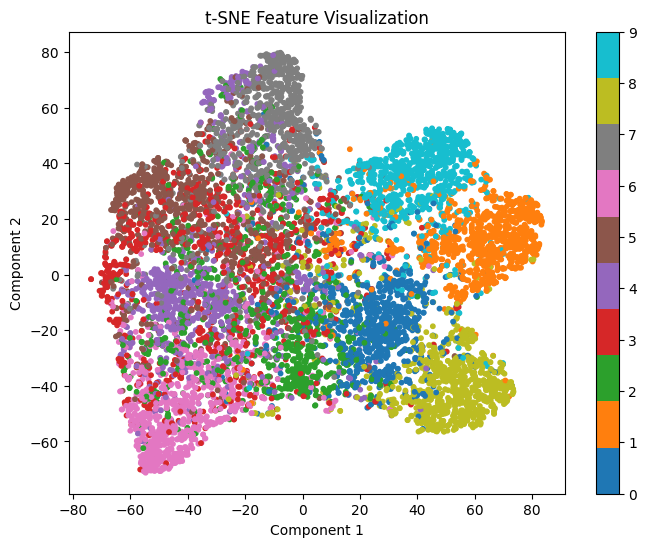

In [21]:
# Make sure you used load_cifar() before this

features, labels = extract_features(model, testloader)

plot_tsne(features, labels)
